In [1]:
!pip install torch torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import resnet18,ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [3]:
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
#normalization parameters
image_mean = (0.485, 0.456, 0.406)
image_std  = (0.229, 0.224, 0.225)

#data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.15, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(image_mean,image_std),
    (transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False))
])

In [5]:
#test transformations
test_transform=transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(image_mean,image_std)
])

In [6]:
#loading train dataset and spliting on train and validation dataset

trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=train_transform)

n = len(trainset)
val_size = int(0.1 * n)
train_size = n - val_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])
val_dataset.dataset.transform = test_transform

100%|██████████| 170M/170M [00:10<00:00, 15.9MB/s] 


In [7]:
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=test_transform)

In [8]:
#data loaders
trainloader=DataLoader(train_dataset,
                       batch_size=128,
                       shuffle=True,
                       num_workers=2)

val_loader=DataLoader(val_dataset,
                       batch_size=128,
                       shuffle=True,
                       num_workers=2)
testloader=DataLoader(testset,
                      batch_size=32,
                      shuffle=False,
                      num_workers=2)

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
print(len(trainset))
print(len(val_dataset))
print(len(testset))

50000
5000
10000


In [11]:
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(image_mean)) + np.array(tuple(image_std))
    img = img.clip(0, 1)
    return img

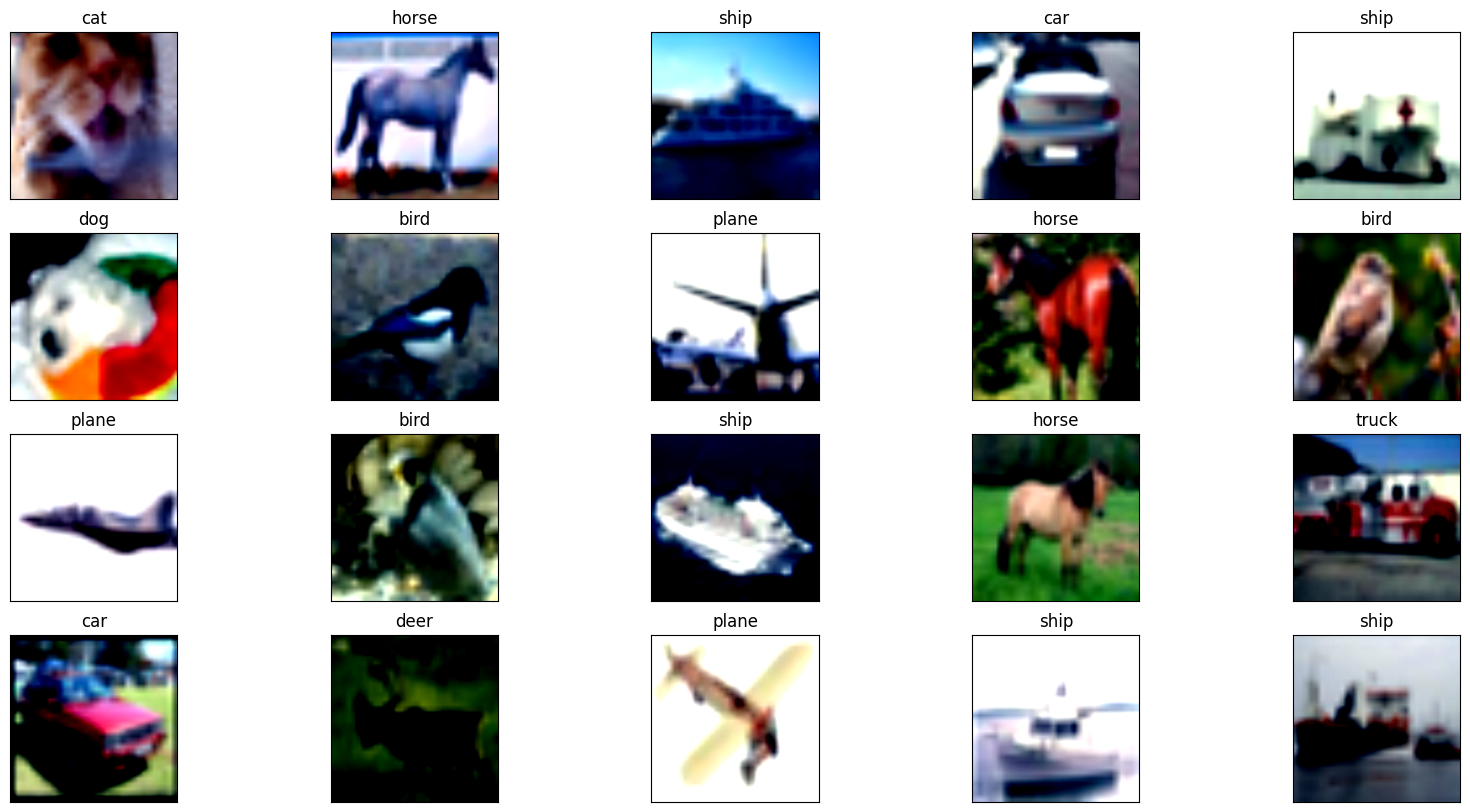

In [12]:
data_iterable = iter(trainloader)
images, labels = next(data_iterable) 
fig = plt.figure(figsize=(20, 10))

for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [13]:
class cifarNN(nn.Module):
    def __init__(self):
        super(cifarNN,self).__init__()
        self.conv1=nn.Conv2d(3,32,3,padding=2)
        self.conv2=nn.Conv2d(32,64,3,padding=2)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*57*57,512)
        self.fc2=nn.Linear(512,10)
        self.drop=nn.Dropout(0.25)
        self.relu=nn.ReLU()

    def forward(self,x):
        x=self.pool(self.relu(self.conv1(x)))
        x=self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 57 * 57)
        x=self.relu(self.fc1(x))
        x=self.drop(x)
        x=self.fc2(x)
        return x

In [14]:
model=cifarNN().to(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)


In [15]:
def train_model(model, trainloader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, loss: {running_loss/len(trainloader):.4f}, val Accuracy: {val_acc:.2f}%")
    return model

model = train_model(model, trainloader, val_loader)

Epoch 1/5, loss: 2.0335, val Accuracy: 45.54%
Epoch 2/5, loss: 1.4027, val Accuracy: 54.76%
Epoch 3/5, loss: 1.1668, val Accuracy: 56.76%
Epoch 4/5, loss: 0.9637, val Accuracy: 56.12%
Epoch 5/5, loss: 0.7566, val Accuracy: 56.28%


In [16]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freezing all layers
for param in resnet.parameters():
    param.requires_grad = False

# replacing classifier head
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet = resnet.to(device)
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet.fc.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = resnet(images)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, loss: {running_loss/len(trainloader):.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


Epoch 1/5, loss: 0.9275
Epoch 2/5, loss: 0.6272
Epoch 3/5, loss: 0.5926
Epoch 4/5, loss: 0.5705
Epoch 5/5, loss: 0.5576


In [17]:
# evaluating accuracy on test set
resnet.eval() 
correct = 0
total = 0

with torch.no_grad(): 
    for images, labels in testloader: 
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")



Test Accuracy: 80.53%


In [18]:
correct, total = 0, 0
resnet.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Transfer learning accuracy: {100 * correct / total:.2f}%")


Transfer learning accuracy: 80.53%


In [19]:
resnet.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"Accuracy of {classes[i]:5s} : {acc:.2f}%")


Accuracy of plane : 85.50%
Accuracy of car   : 89.20%
Accuracy of bird  : 69.00%
Accuracy of cat   : 71.10%
Accuracy of deer  : 79.80%
Accuracy of dog   : 74.40%
Accuracy of frog  : 82.30%
Accuracy of horse : 83.00%
Accuracy of ship  : 84.90%
Accuracy of truck : 86.10%


In [20]:
misclassified_data = []
resnet.eval()

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        misclassified_mask = (predicted != labels)
        misclassified_images = images[misclassified_mask]
        misclassified_labels = labels[misclassified_mask]
        misclassified_predictions = predicted[misclassified_mask]

        for i in range(misclassified_images.size(0)):
            misclassified_data.append({
                'image': misclassified_images[i].cpu(),
                'true_label': misclassified_labels[i].item(),
                'predicted_label': misclassified_predictions[i].item()
            })


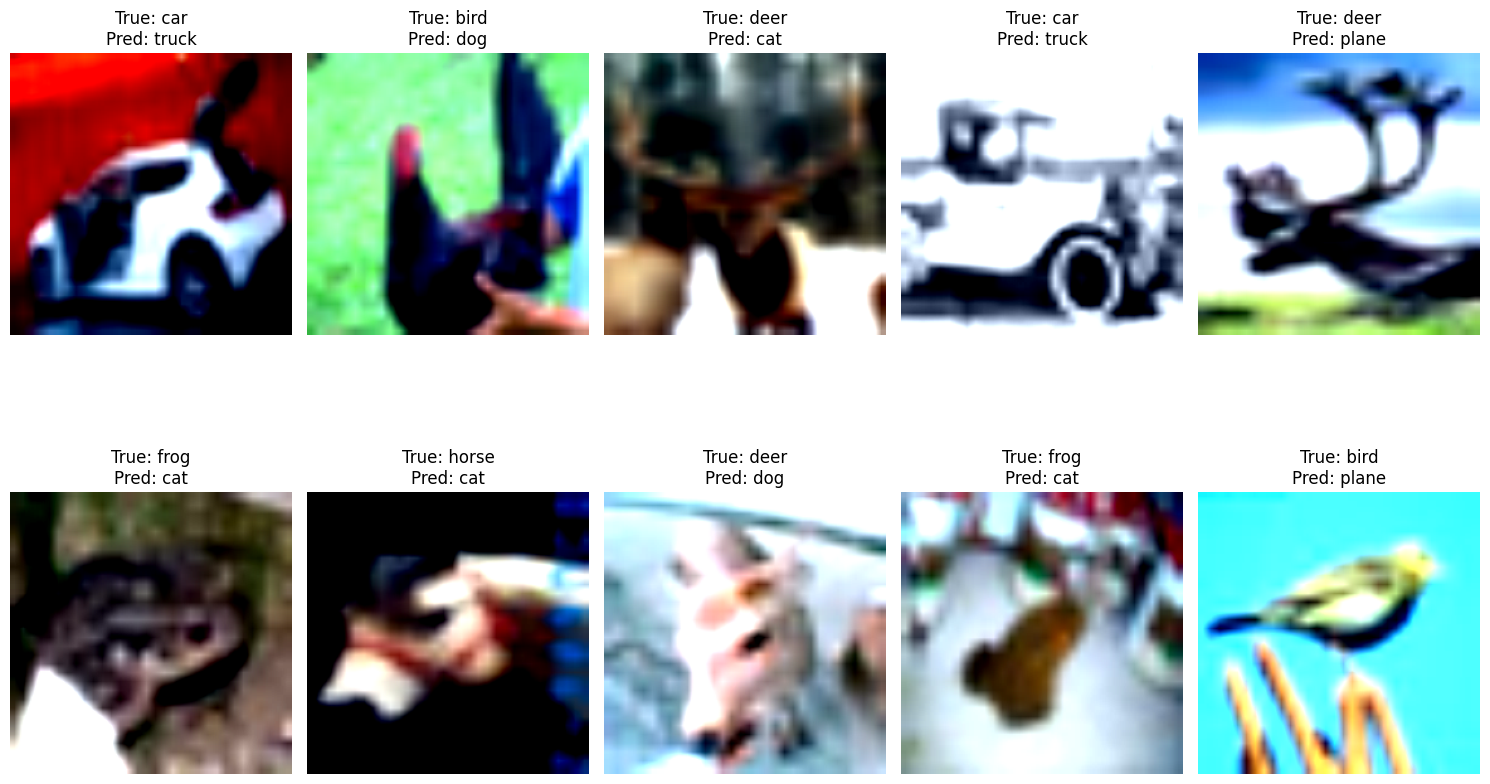

In [21]:
display_count = 10  
misclassified_subset = misclassified_data[:display_count]

plt.figure(figsize=(15, 10))
for i, data in enumerate(misclassified_subset):
    image = data['image']
    true_label = data['true_label']
    predicted_label = data['predicted_label']

    # Unnormalize and convert to NumPy array
    img = image / 2 + 0.5  # Unnormalize
    npimg = img.numpy()

    plt.subplot(2, 5, i + 1)  # Adjust subplot grid as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"True: {classes[true_label]}\nPred: {classes[predicted_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

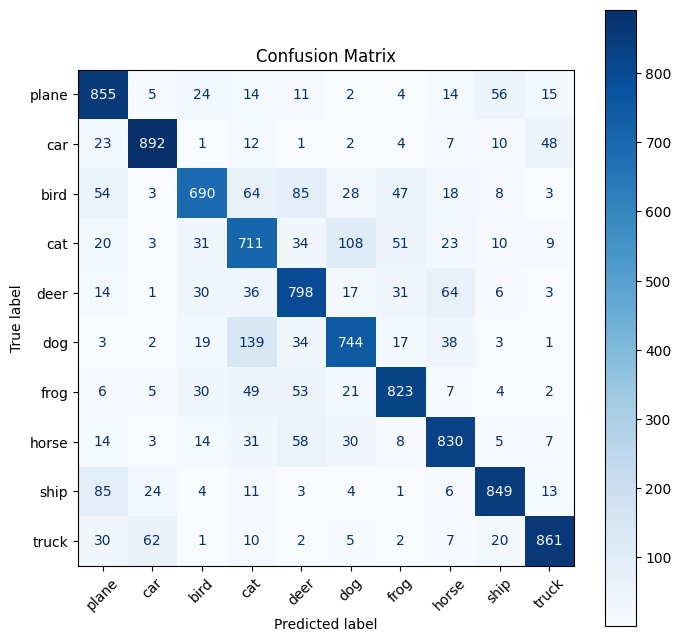

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, classes):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8,8))
    cmd.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(resnet, testloader, classes)

In [23]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []
resnet.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("classification report for ResNet18:")
print(classification_report(y_true, y_pred, target_names=classes))

classification report for ResNet18:
              precision    recall  f1-score   support

       plane       0.77      0.85      0.81      1000
         car       0.89      0.89      0.89      1000
        bird       0.82      0.69      0.75      1000
         cat       0.66      0.71      0.68      1000
        deer       0.74      0.80      0.77      1000
         dog       0.77      0.74      0.76      1000
        frog       0.83      0.82      0.83      1000
       horse       0.82      0.83      0.82      1000
        ship       0.87      0.85      0.86      1000
       truck       0.90      0.86      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

